<center>
    <h1>Analyzing data and preprocessing</h1>
</center>

In this notebook, we will explore and prepare a dataset to extract valuable insights and trends. Our aim is to provide actionable information that can be used to train the model.

<table align="left">
    <td>
        <a href="https://colab.research.google.com/github/dailoht/Epitech_Zoidberg2.0/blob/main/notebooks/data_processing/pab-analyze_full_db.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
    </td>
</table>

# 1. Setup

In [1]:
# Import base librairies
import sys
from pathlib import Path
from PIL import Image

# Import scientific librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Keras
from tensorflow import keras

# Check running environment
try:
    import google.colab
    IN_COLAB=True
except:
    IN_COLAB=False

# Add project directory to kernel paths
if IN_COLAB:
    print("We're running on Colab")
    !git clone https://github.com/dailoht/Epitech_Zoidberg2.0.git
    sys.path.append('./Epitech_Zoidberg2.0')
else:
    print("We're running localy")
    sys.path.append('../..')

2023-03-28 22:54:58.280250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We're running localy


In [2]:
# Import custom functions
from src.visualization.plot_lib import default_viz
from src.data.file_manager import FileManager
from src.data.tf_utils import save_image_dataset_to_tfrecord, load_image_dataset_from_tfrecord

zoidbergManager = FileManager()

# Set default graphics visualization
%matplotlib inline
default_viz()

# 2. Transform data into a common dataset

Before starting any analysis on the data, we just transform the data folder structure into a more convinient one:
- we remove train, val and set folder as we will split data later
- we provide 3 folders : one by class

This folder is in the interim data folder.

In [3]:
zoidbergManager.fetch_full_dataset()
print('')
is_ok = zoidbergManager.check_full_dataset(print_result=True)

Full dataset already created

full dataset : class normal => nb images = 1583
full dataset : class bacteria => nb images = 2780
full dataset : class virus => nb images = 1493
----------------------------------------
raw data     : class bacteria => nb images = 2780
raw data     : class normal => nb images = 1583
raw data     : class virus => nb images = 1493


Then, we will create a DataFrame that contains metadata of each images in orders to analyse those images. Metadata we want to get are : 
 - Filename
 - Size of the image
 - Number of channels e.g. grayscale, rbg, rgba, so on
 - Label of the image  : normal, virus, bacteria

In [4]:
metadata = []
for img_path in Path(zoidbergManager.data_dir / "interim" / "full").rglob('*.jpeg'):
    with Image.open(img_path) as img:
        label = img_path.parents[0].name
        width, height = img.size
        channels = len(img.getbands())
        
        metadata.append((img_path.name, width, height, channels, label))

metadata_df = pd.DataFrame(metadata, columns=["image", "width", "height", "channels", "label"])

metadata_df.head()

,image,width,height,channels,label
0,normal_img_1280.jpeg,1546,1271,1,normal
1,normal_img_0868.jpeg,1504,1174,1,normal
2,normal_img_0491.jpeg,1786,1360,1,normal
3,normal_img_0184.jpeg,1450,1149,1,normal
4,normal_img_0887.jpeg,912,672,1,normal


# 3. Metadata analysis

Let's to get some insight by image metadata. We want to know image size and number of channels in order to resize them for CNN. We can also detect some outliers with those features. 

In [5]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5856 non-null   object
 1   width     5856 non-null   int64 
 2   height    5856 non-null   int64 
 3   channels  5856 non-null   int64 
 4   label     5856 non-null   object
dtypes: int64(3), object(2)
memory usage: 228.9+ KB


So, we have $5856$ images, for each of those, we were able to detect its size (*width* $\times$ *height*) and what kind of image it is (Grayscale, RGB, etc...). The numbers of images seems a bit short for deep learning, even if we will use **transfer learning**. We will probably need *data augmentation*.

### 3.1 Size & Channels

In [6]:
metadata_df.describe()

,width,height,channels
count,5856.000000,5856.000000,5856.000000
mean,1327.880806,970.689037,1.096653
std,363.500922,383.392117,0.428947
min,384.000000,127.000000,1.000000
25%,1056.000000,688.000000,1.000000
50%,1281.000000,888.000000,1.000000
75%,1560.000000,1187.000000,1.000000
max,2916.000000,2713.000000,3.000000


Clearly, the size of the images are widely distributed :
- width : from $384$ to $2916$ pixels
- height : from $127$ to $2713$ pixels

Most of images are grayscale (more than $75\%$) but some are also consiedered RGB. 


As their size distribution is not peaky, let's plot it in a violin plot :

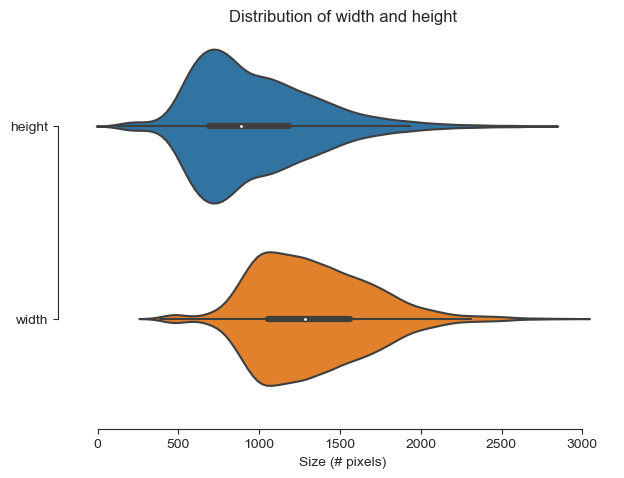

In [7]:
sns.set_style('ticks')
vp = sns.violinplot(data=metadata_df[['height','width']], orient='h')
vp.set_title("Distribution of width and height")
vp.set_xlabel("Size (# pixels)", fontsize=10)
sns.despine(offset=10, trim=True)


What we have plot is a violin plot : horizontal box corresponds to quantiles with the mean at the white dot. The colored space is the kernel density of a distribution.  
According to this violin plot, it appears that we will be able to resize images around $500\times 500$ without having to oversize too many images (oversizing can create blur in the image).


Let's now focus on channels and count how many images have a RGB channel : 

In [8]:
print(metadata_df['channels'].value_counts())

1    5573
3     283
Name: channels, dtype: int64


So, it turns out that $5\%$ of our dataset is considered to have a RGB, the rest have grayscale color. Let's try to display some of these images to see what they look like :

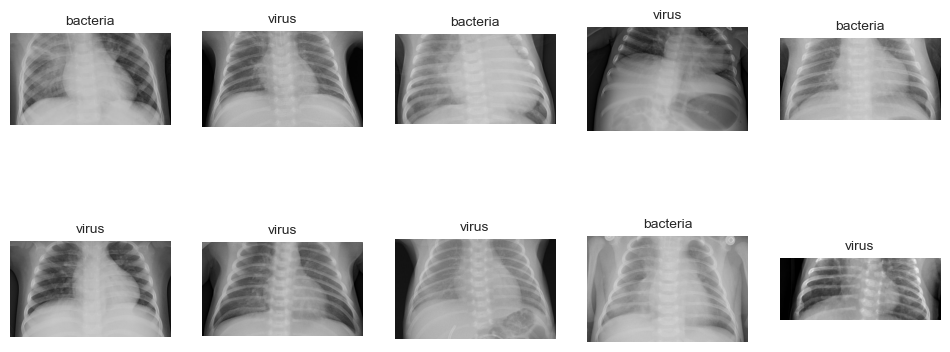

In [9]:
rgb_channel_df = metadata_df[metadata_df['channels'] == 3].sample(n=10, random_state=42)

fig, axes = plt.subplots(nrows=2, ncols=5,figsize=(12,5))
for i, ax in enumerate(axes.flat):
    if i < len(rgb_channel_df):
        image_name = rgb_channel_df['image'].iloc[i]
        image_dir = rgb_channel_df['label'].iloc[i]
        image_path = Path(zoidbergManager.data_dir / "interim" / "full" / image_dir / image_name)
        image = Image.open(image_path)
        ax.imshow(image)
        ax.set_title(image_dir,fontsize=10)
        ax.set_axis_off()
plt.show()

Everything is fine, it looks like that they were classified as RGB by the package `pyllow` but they are indeed black & white pictures. 

### 3.2 Labels

Finally, let's talk about labels. The most important thing we want to know is are there imbalanced classes (i.e if one class has much more data than the others). Class imbalance can make classification more challenging by biasing the model towards the majority class, leading to poor performance on the minority class, and misleading evaluation metrics.  
Thus, we display histogram for each class : 

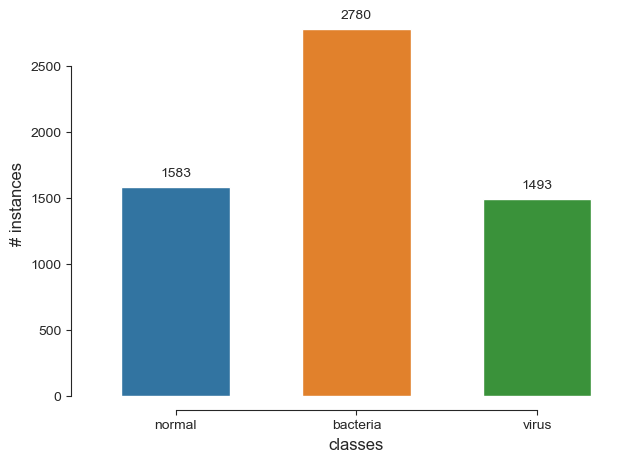

In [10]:
cp = sns.countplot(data = metadata_df, x='label', width=0.6)
cp.set_xlabel('classes')
cp.set_ylabel('# instances')
sns.despine(offset=10, trim=True)

for p in cp.patches:
    cp.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

**Bacteria class has widely twice times more records than normal and virus !**  
So, we need to handle class imbalance. We will do it by :
- do not choose accuracy as metrics but prefer $F_1$ - score
- set class weights inside our loss function.

# 4. TF dataset & train/test split

Once we have completed the data analysis phase, the next step is to prepare data for modeling. Thus, let's split our data into training, validation, and testing sets using TensorFlow, its `tf.data` library.

First, we define some useful hyper-parameters : 

In [11]:
img_height = 512
img_width = 512
channels = "rgb"
test_split = 0.2
val_split = 0.25

We will use the function `image_dataset_from_directory` to split train and test and load them into tensorflow datasets. We load images in a rgb mode (3 channels) and resize them $512\times 512$ :

In [12]:
train_ds, full_test_ds = keras.utils.image_dataset_from_directory(
    directory=Path(zoidbergManager.data_dir / "interim" / "full"),
    label_mode="categorical",
    color_mode=channels,
    batch_size=None,
    image_size=(img_height, img_width),
    seed=42,
    validation_split=test_split,
    subset="both"
)

def count_img_by_class(dataset, class_names=train_ds.class_names):
    num_img_by_classes = {name:0 for name in class_names}
    for images, labels in dataset:
        idx_label = np.nonzero(labels.numpy())[0][0]
        for idx, name in enumerate(class_names):
            if idx_label == idx:
                num_img_by_classes[name] += 1
    return num_img_by_classes

num_train_img = train_ds.reduce(0, lambda x, _: x + 1).numpy()
num_test_img = full_test_ds.reduce(0, lambda x, _: x + 1).numpy()

train_img_by_classes = count_img_by_class(train_ds)
full_test_img_by_classes = count_img_by_class(full_test_ds)

print("\nIn training dataset, there are :")
for class_name, num_img in train_img_by_classes.items():
    print(f"  - {num_img} files for class {class_name}")    
print("\nIn full test dataset, there are :")
for class_name, num_img in full_test_img_by_classes.items():
    print(f"  - {num_img} files for class {class_name}")

Found 5856 files belonging to 3 classes.
Using 4685 files for training.
Using 1171 files for validation.


2023-03-28 22:55:14.229097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



In training dataset, there are :
  - 2252 files for class bacteria
  - 1251 files for class normal
  - 1182 files for class virus

In full test dataset, there are :
  - 528 files for class bacteria
  - 332 files for class normal
  - 311 files for class virus


Let's then divide the full training set into training and validation set :

In [13]:
val_size = int(num_test_img * val_split)

full_test_ds.shuffle(buffer_size=num_train_img, seed=42)

val_ds = full_test_ds.take(val_size)
test_ds = full_test_ds.skip(val_size)

val_img_by_classes = count_img_by_class(val_ds)
test_img_by_classes = count_img_by_class(test_ds)

print("In validation dataset, there are :")
for class_name, num_img in val_img_by_classes.items():
    print(f"  - {num_img} files for class {class_name}")    
print("\nIn test dataset, there are :")
for class_name, num_img in test_img_by_classes.items():
    print(f"  - {num_img} files for class {class_name}")

In validation dataset, there are :
  - 137 files for class bacteria
  - 83 files for class normal
  - 72 files for class virus

In test dataset, there are :
  - 391 files for class bacteria
  - 249 files for class normal
  - 239 files for class virus


Finally, we save them in a `TFRecord`format which is a conveninet binary format used by tensorflow to save data :

In [14]:
train_path = str(zoidbergManager.data_dir / 'processed' / f'train_{img_height}x{img_width}_{channels}_ds.tfrecord')
val_path = str(zoidbergManager.data_dir / 'processed' / f'val_{img_height}x{img_width}_{channels}_ds.tfrecord')
test_path = str(zoidbergManager.data_dir / 'processed' / f'test_{img_height}x{img_width}_{channels}_ds.tfrecord')

save_image_dataset_to_tfrecord(train_ds, train_path)
save_image_dataset_to_tfrecord(val_ds, val_path)
save_image_dataset_to_tfrecord(test_ds, test_path)

Let's just check if we have those savings performed well :

In [15]:
loaded_val_ds = load_image_dataset_from_tfrecord(val_path)

print("In loaded validation dataset, there are :")
for class_name, num_img in val_img_by_classes.items():
    print(f"  - {num_img} files for class {class_name}") 

In loaded validation dataset, there are :
  - 137 files for class bacteria
  - 83 files for class normal
  - 72 files for class virus


(-0.5, 511.5, 511.5, -0.5)

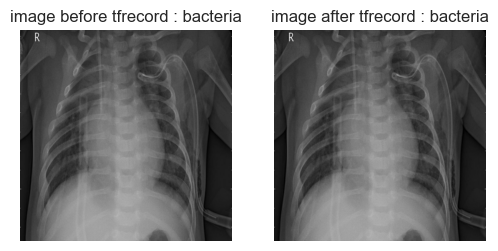

In [16]:
image_val_1, label_val_1 = next(val_ds.take(1).as_numpy_iterator())
image_load_val_1, label_load_val_1 = next(loaded_val_ds.take(1).as_numpy_iterator())

plt.figure(figsize=(6,10))
plt.subplot(121)
plt.imshow(image_val_1.astype('int64'))
plt.title(f'image before tfrecord : {train_ds.class_names[np.nonzero(label_val_1)[0][0]]}')
plt.axis("off")
plt.subplot(122)
plt.imshow(image_load_val_1)
plt.title(f'image after tfrecord : {train_ds.class_names[np.nonzero(label_load_val_1)[0][0]]}')
plt.axis("off")